# Load libraries

In [1]:
library("Matrix")
library("tidyverse")
library("ggnewscale")
library("ggrastr")
library("gridExtra")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Config

In [2]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=200)

In [3]:
theme_set(theme_classic() + theme(strip.background=element_blank(), strip.text=element_text(hjust=0), axis.text.y=element_text(angle=90, hjust=0.5)))

# Load data

In [4]:
mat <- readMM("computed/ifnagrko_raw_counts.mtx.gz")
obs <- read_csv("computed/ifnagrko_obs.csv") %>% 
    left_join(read_csv("computed/hto_assignment.csv")) %>% 
    mutate(celltype2=ifelse(celltype2 == "nan", NA, celltype2))
var <- read_csv("computed/ifnagrko_var.csv") %>% select(gene_name, gene_id)
rownames(mat) <- obs$barcode
colnames(mat) <- var$gene_name
mat[1:5,1:5]

Rows: 18302 Columns: 17

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): barcode, celltype, celltype1, celltype2, age, genotype
dbl (11): dpt_pseudotime, svz_frac, hto_sum, leiden, dbscan, frac_mito, coun...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 18302 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): barcode, hto_ass, hto_zone
dbl (2): hto_repl, hto_sum


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Joining, by = c("barcode", "hto_sum")

New names:
* `` -> ...1

Rows: 20830 Columns: 3

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gene_name, gene_id
dbl (1): ...1


ℹ Use `sp

5 x 5 sparse Matrix of class "dgTMatrix"
                                  Xkr4 Rp1 Sox17 Gm37323 Mrpl15
AAACCCAGTCTCCTGT-WT_20mo_2021_001    .   .     .       .      .
AAACGAAAGGTACTGG-WT_20mo_2021_001    .   .     .       .      .
AAACGAACATGGCTGC-WT_20mo_2021_001    .   .     .       .      .
AAACGAAGTAGCTGAG-WT_20mo_2021_001    .   .     .       .      .
AAACGAATCACCCTCA-WT_20mo_2021_001    .   .     .       .      1

In [5]:
sets.list <- Map(function(x) {readLines(str_glue("genesets/{x}.txt"))}, str_split(dir("genesets"), "\\.", simplify=T)[,1])

# Processing

In [6]:
frac <- mat/rowSums(mat)

# Signature plots

Joining, by = "barcode"

`summarise()` has grouped output by 'set', 'age', 'genotype', 'celltype'. You can override using the `.groups` argument.

Joining, by = "celltype"



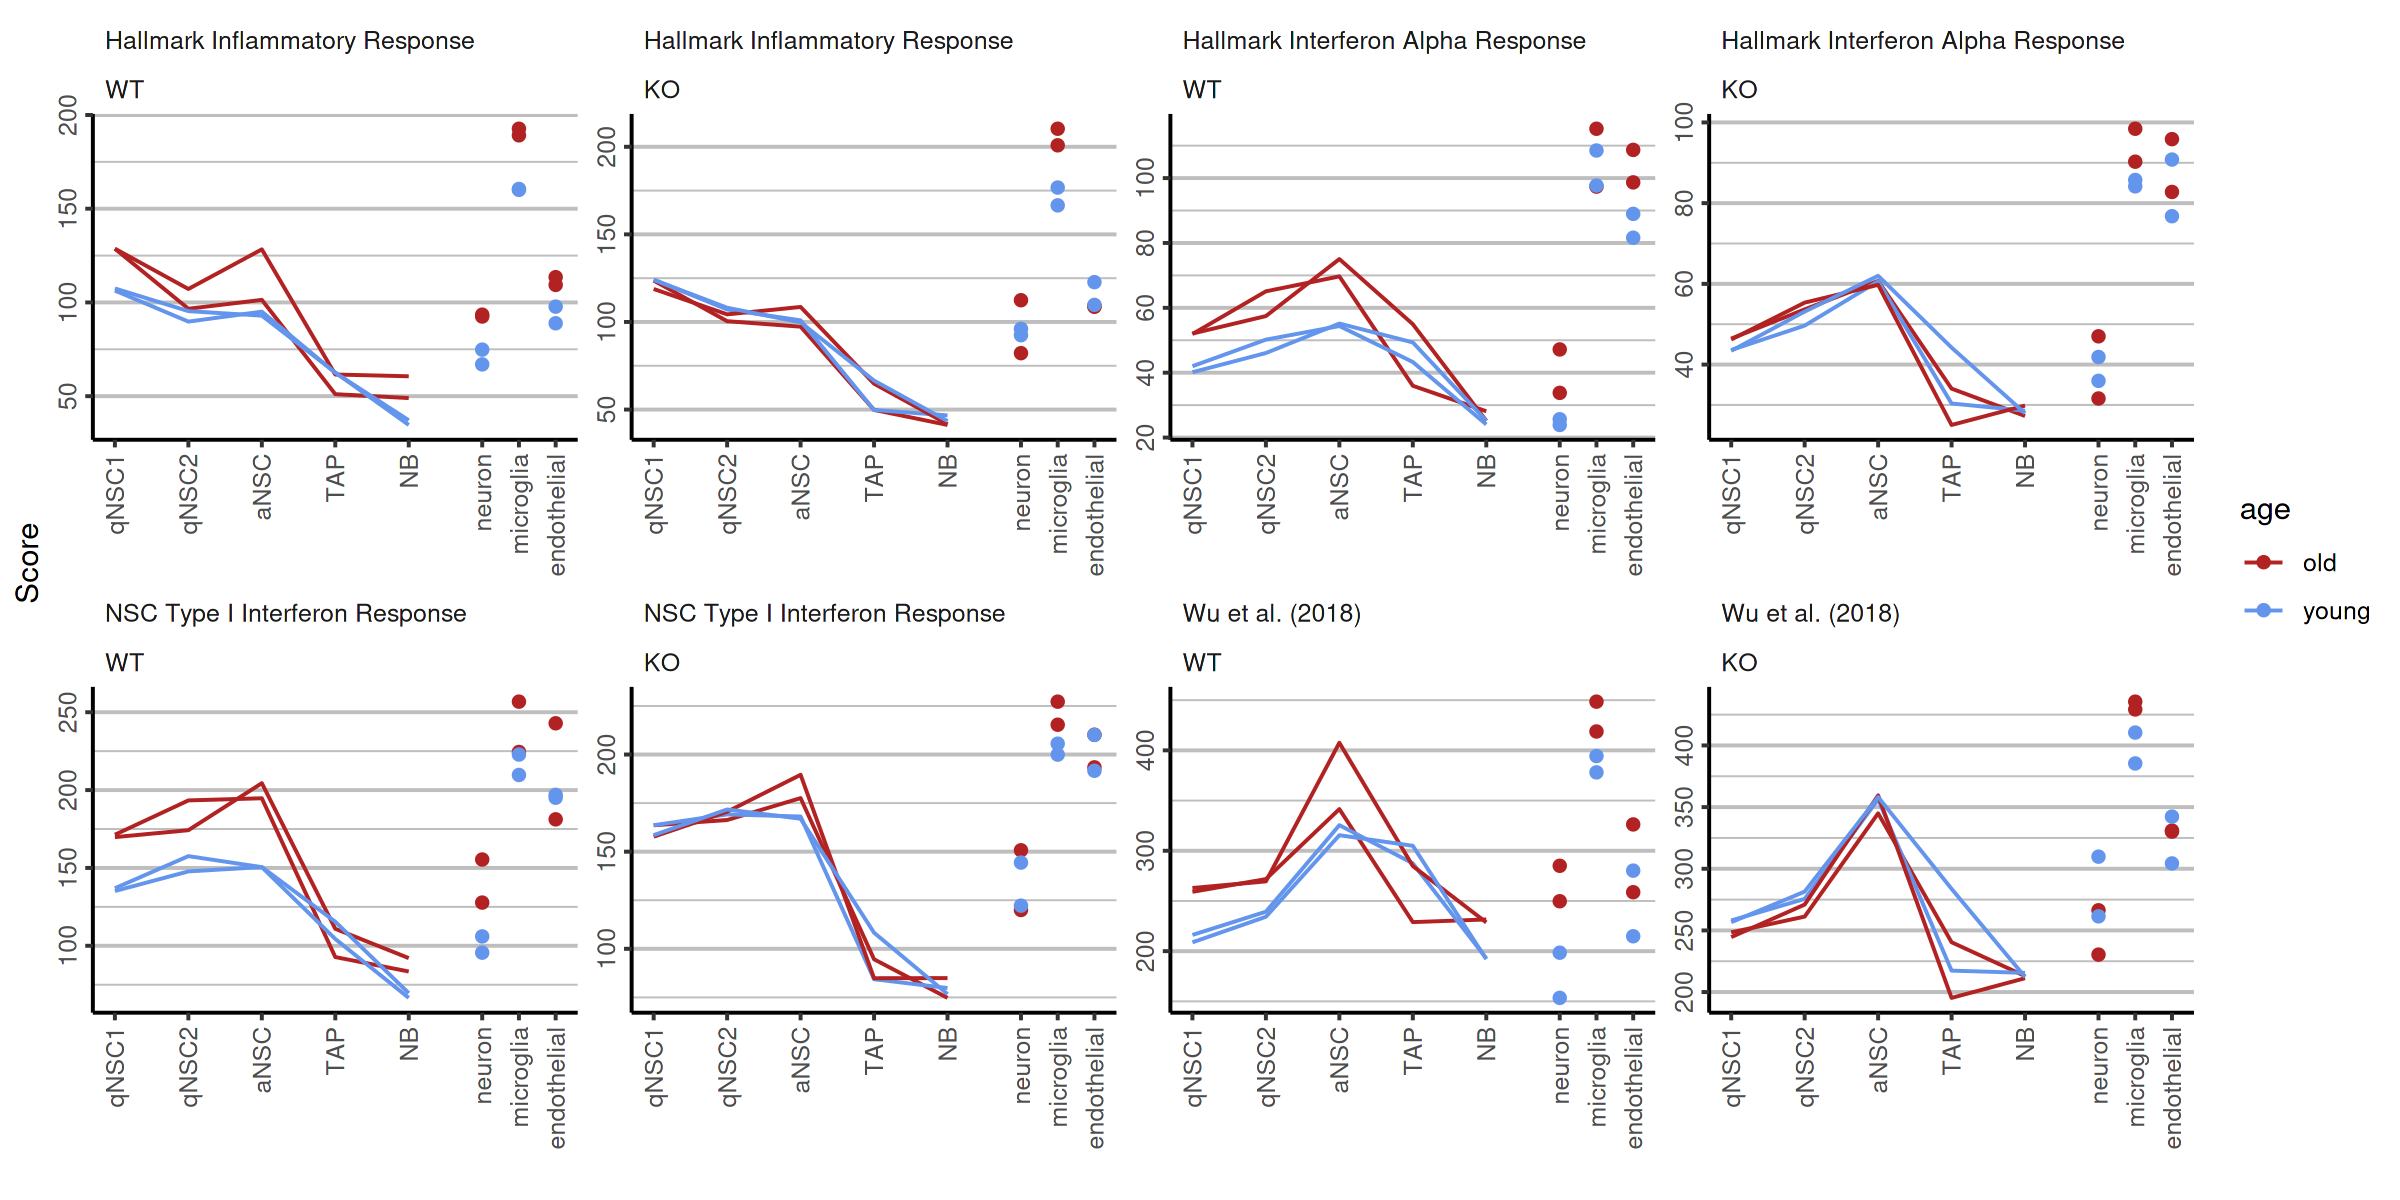

In [7]:
base_s <- 6
options(repr.plot.height=base_s, repr.plot.width=base_s*2)
type.long.order <- c("lineage:qNSC1", "lineage:qNSC2", "lineage:aNSC", "lineage:TAP", "lineage:NB", "neuron", "microglia", "endothelial")#, "oligo", "opc", "ob astrocyte", "ependymal")
type.order <- str_remove(type.long.order, "lineage:")
pos <- tibble(celltype=type.long.order, x=c(0, 1, 2, 3, 4, 5, 5.5, 6))
this.d <- names(sets.list) %>%
    mapply(function(this.name) { rowSums(log1p(1e6 * frac[,intersect(colnames(frac), sets.list[[this.name]])])) },  .) %>%
    as.data.frame %>%
    mutate(barcode=rownames(.)) %>%
    pivot_longer(-barcode, names_to="set", values_to="score") %>%
    left_join(obs) %>%
    filter(celltype %in% type.long.order, !is.na(hto_repl)) %>%
    group_by(set, age, genotype, celltype, hto_repl) %>%
    summarise(score=mean(score)) %>% 
    ungroup() %>%
    mutate(celltype_short=str_remove(celltype, "lineage:"),
           celltype_short=factor(celltype_short, type.order),
           celltype=factor(celltype, type.long.order),
           age=factor(age, c("young", "old")), 
           genotype=factor(genotype, c("WT", "KO")),
           set=case_when(str_detect(set, "HALLMARK") ~ set %>% str_replace_all("_", " ") %>% str_to_title(),
                         set == "wu" ~ "Wu et al. (2018)",
                         set == "skabkin300" ~ "NSC Type I Interferon Response")) %>%
    left_join(pos)
this.d %>%
    ggplot(aes(x, score, colour=age)) +
    facet_wrap(set~genotype, scales="free", ncol=4) +
    scale_colour_manual(values=c("old"="firebrick", "young"="cornflowerblue")) +
    scale_x_continuous(labels=str_remove(pos$celltype, "lineage:"), breaks=pos$x) + 
    labs(x="", y="Score") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
          panel.grid.major.y=element_line(colour="gray"),
          panel.grid.minor.y=element_line(colour="gray", size=rel(0.5))) +
    geom_point(colour="transparent") +
    geom_point(data=filter(this.d, !str_detect(celltype, "lineage"))) +
    geom_line(aes(group=paste(hto_repl, age, genotype)), data=filter(this.d, str_detect(celltype, "lineage")))

png 
  2

png 
  2

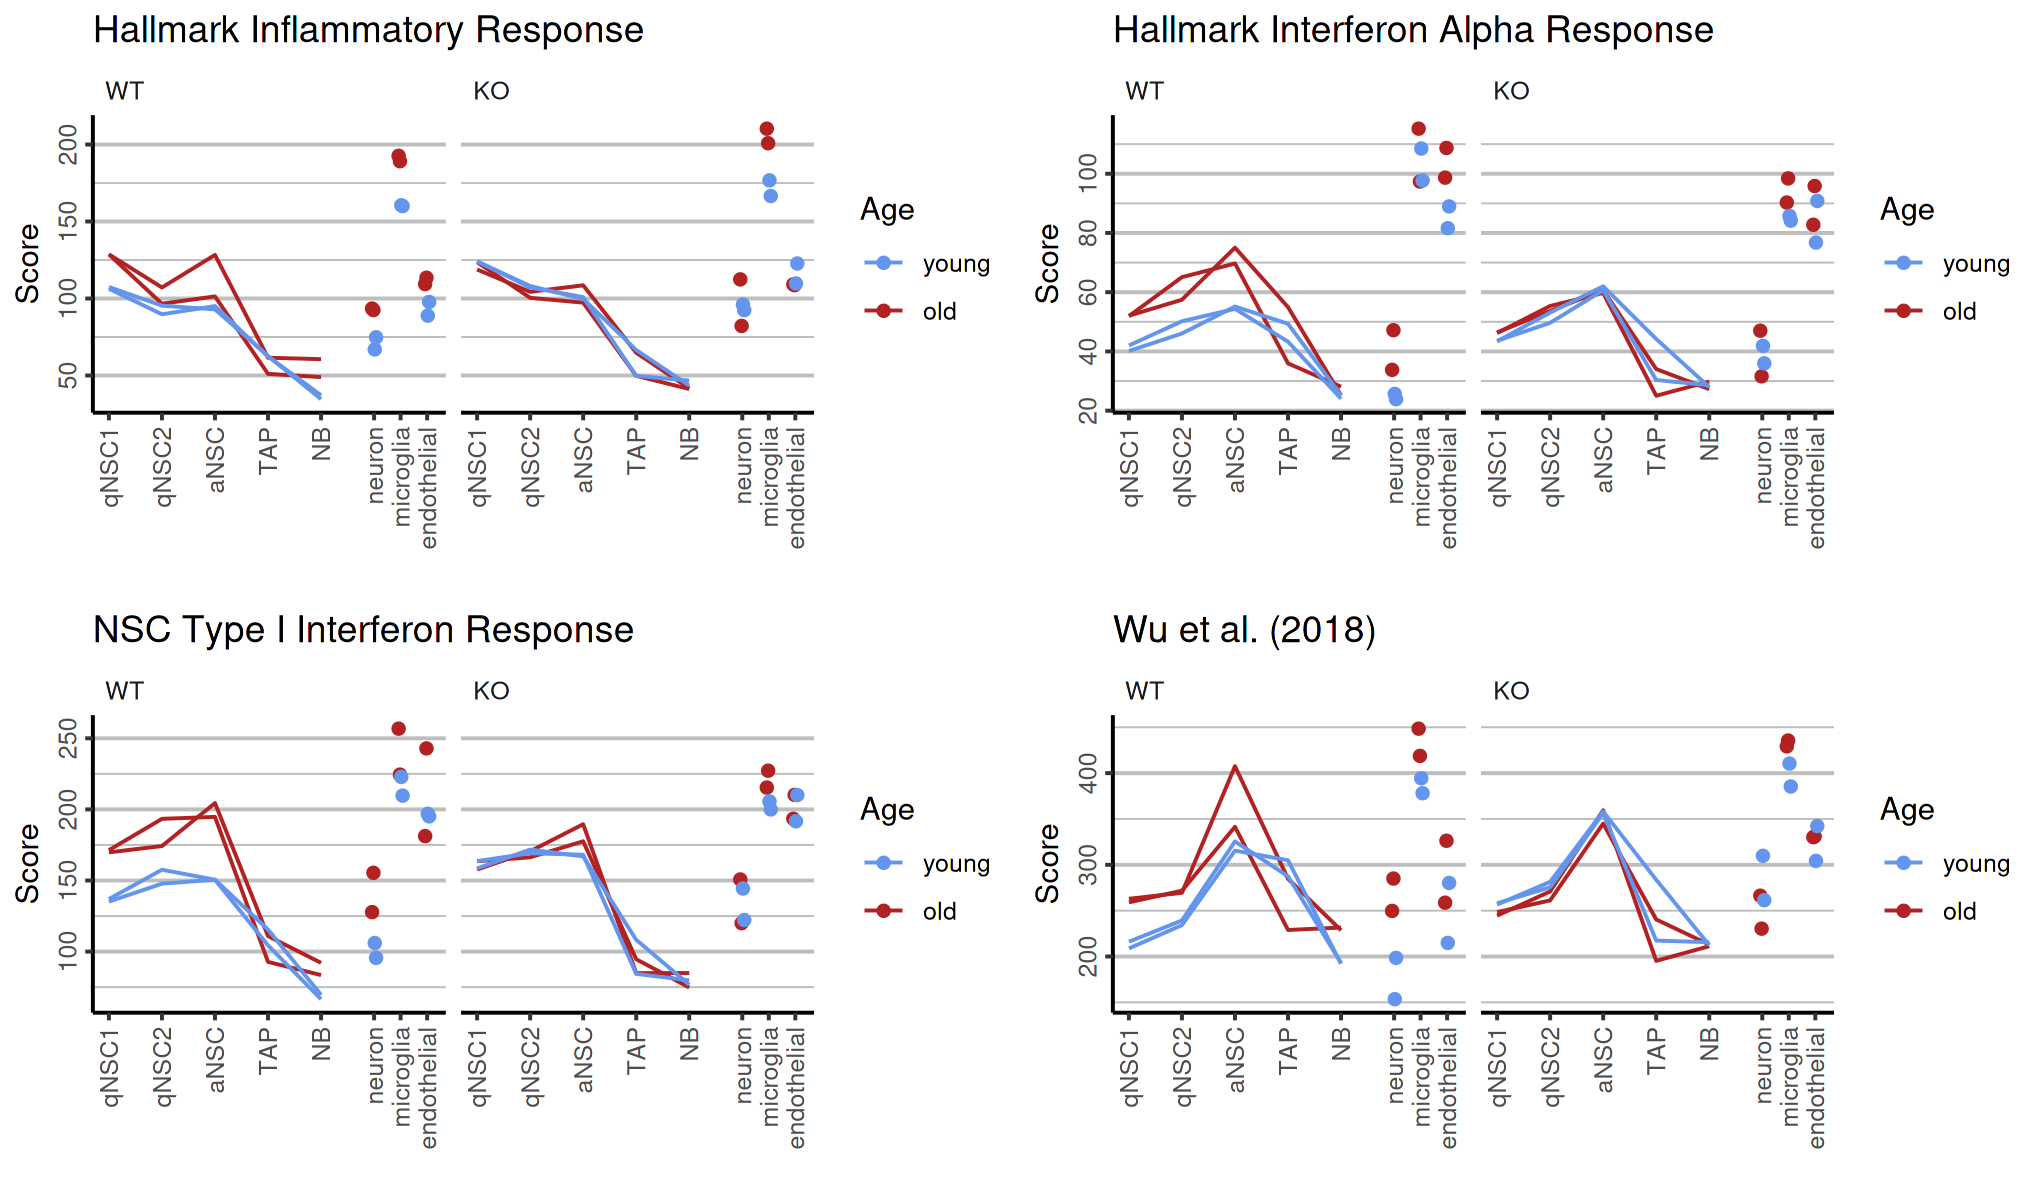

In [8]:
base_s <- 6
options(repr.plot.height=base_s, repr.plot.width=base_s*1.7)
ps <- Map(function(this.name) {
    type.long.order <- c("lineage:qNSC1", "lineage:qNSC2", "lineage:aNSC", "lineage:TAP", "lineage:NB", "neuron", "microglia", "endothelial")#, "oligo", "opc", "ob astrocyte", "ependymal")
    #this.name <- "skabkin300"
    type.order <- str_remove(type.long.order, "lineage:")
    this.d <- rowSums(log1p(1e6 * frac[,intersect(colnames(frac), sets.list[[this.name]])])) %>%
        enframe(name="barcode", value="score") %>%
        left_join(obs, by="barcode") %>%
        #mutate(celltype_short=str_remove(celltype, "lineage:")) %>%
        filter(celltype %in% type.long.order, !is.na(hto_repl)) %>%
        group_by(age, genotype, celltype, hto_repl) %>%
        summarise(score=mean(score), .groups="drop") %>% 
        mutate(celltype_short=str_remove(celltype, "lineage:"),
               celltype_short=factor(celltype_short, type.order),
               celltype=factor(celltype, type.long.order),
               age=factor(age, c("young", "old")), 
               genotype=factor(genotype, c("WT", "KO")),
              )
    pos <- tibble(celltype=type.long.order, x=c(0, 1, 2, 3, 4, 5, 5.5, 6))
    this.name <- case_when(
        str_detect(this.name, "HALLMARK") ~ this.name %>% str_replace_all("_", " ") %>% str_to_title(),
        this.name == "wu" ~ "Wu et al. (2018)",
        this.name == "skabkin300" ~ "NSC Type I Interferon Response",
        T ~ this.name
    )
    this.d <- this.d %>%
        left_join(pos, by="celltype")
    this.d %>%
        ggplot(aes(x, score, colour=age, group=paste(genotype, age, hto_repl))) +
        geom_point(colour="transparent") +
        geom_line(data=filter(this.d, str_detect(celltype, "lineage:"))) +
        geom_point(data=filter(this.d, !str_detect(celltype, "lineage:")), position=position_dodge(width=0.1)) +
        scale_x_continuous(labels=str_remove(pos$celltype, "lineage:"), breaks=pos$x) + 
        #scale_x_discrete(breaks=1:length(type.order), labels=type.order) +
        scale_colour_manual(values=c("young"="cornflowerblue", "old"="firebrick")) +
        labs(title=this.name, x="", y="Score", colour="Age") +
        theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
              panel.grid.major.y=element_line(colour="gray"),
              panel.grid.minor.y=element_line(colour="gray", size=rel(0.5))) +
        facet_wrap(~genotype)
}, names(sets.list))
ps$ncol <- 2
do.call(grid.arrange, ps)
dev.print(pdf, "plots/signatures.pdf", height=6, width=6*1.7)
dev.print(svglite::svglite, "plots/signatures.svg", width=6*1.7, height=6, fix_text_size=F)

Joining, by = "barcode"



png 
  2

png 
  2

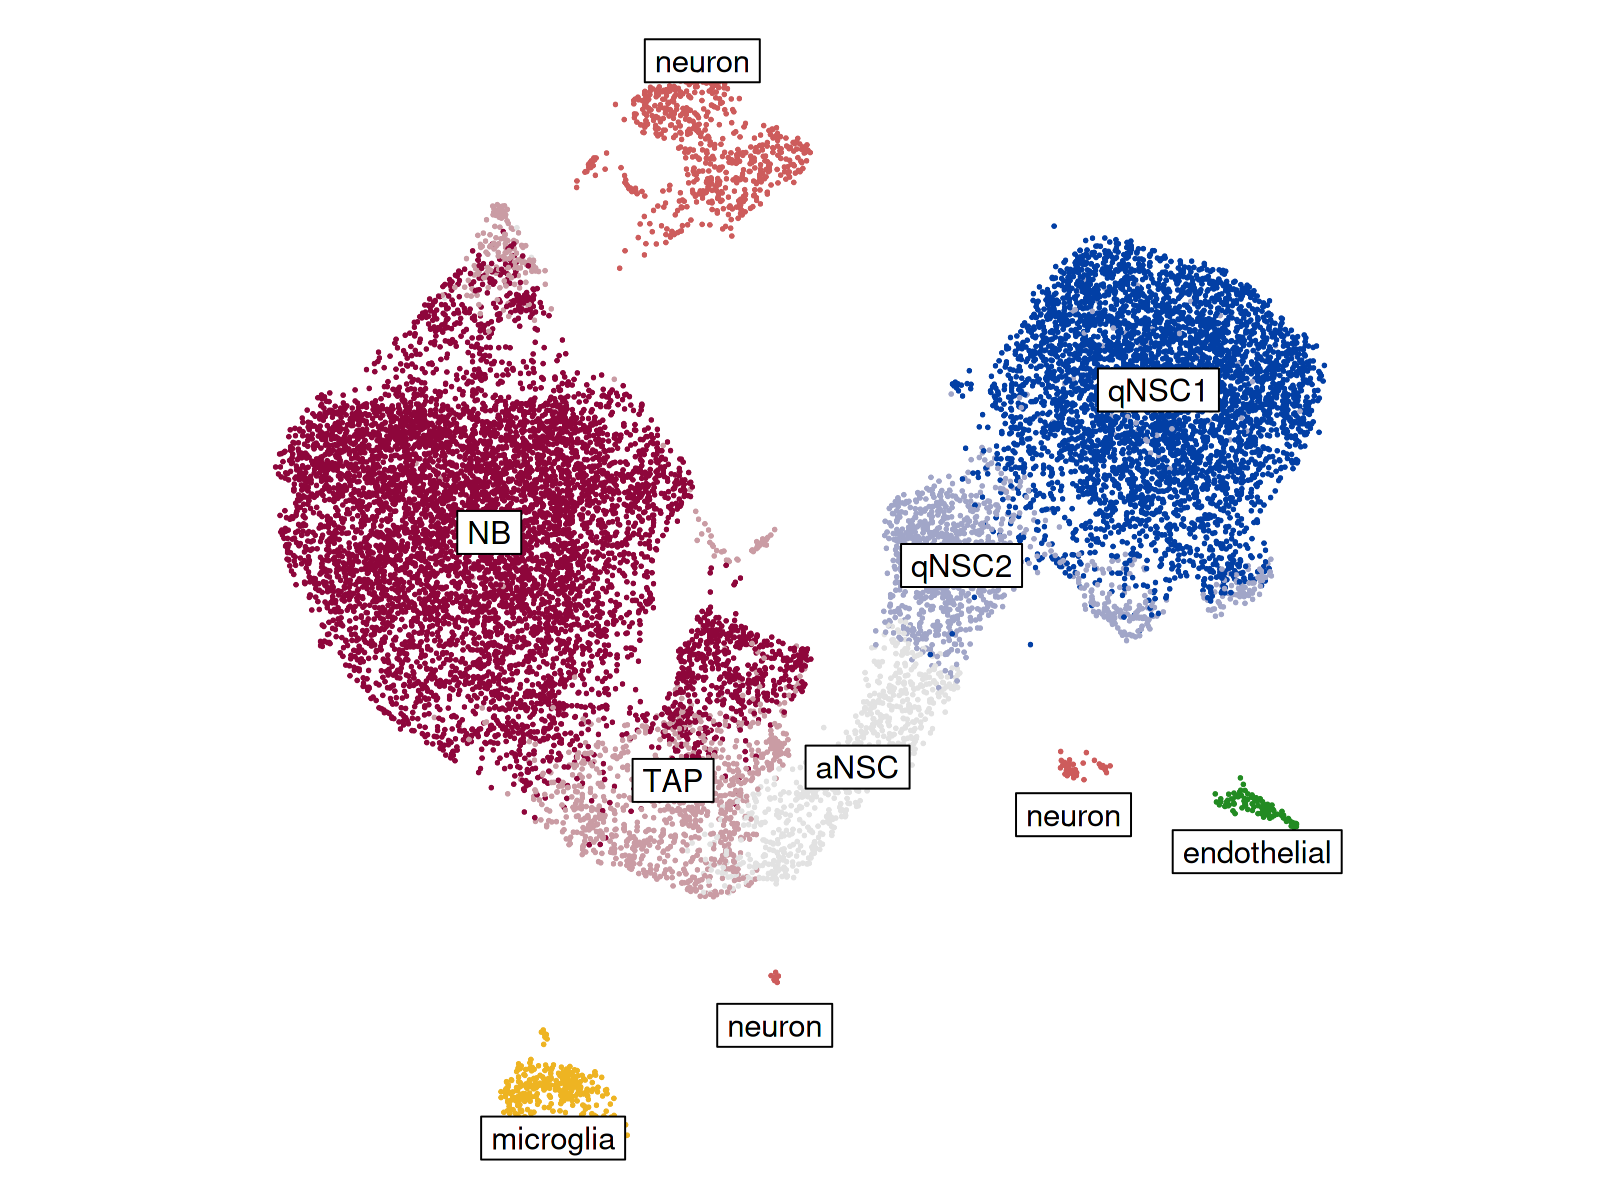

In [9]:
base_s <- 6
options(repr.plot.height=base_s, repr.plot.width=8)
type.order <- c("qNSC1", "qNSC2", "aNSC", "TAP", "NB", "microglia", "endothelial", "neuron")
this.cols <- c(hcl.colors(5, "Blue-Red")[1:5], "goldenrod2", "forestgreen", "indianred")
this.name <- "skabkin300"
this.d <- rowSums(log1p(1e6 * frac[,intersect(colnames(frac), sets.list[[this.name]])])) %>%
    enframe(name="barcode", value="score") %>%
    left_join(obs) %>%
    mutate(celltype=str_remove(celltype, "lineage:")) %>%
    filter(celltype %in% type.order) %>%
    mutate(celltype=factor(celltype, type.order))
names(this.cols) <- type.order
this.d.lin <-  this.d %>%
    filter(!is.na(celltype2)) %>%
    group_by(celltype) %>%
    summarise(UMAP1=median(UMAP1), UMAP2=median(UMAP2))
this.d.off <-  this.d %>%
    filter(is.na(celltype2)) %>%
    group_by(dbscan) %>%
    summarise(UMAP1=median(UMAP1), UMAP2=median(UMAP2), celltype=celltype[1])
this.d %>%
    ggplot(aes(UMAP1, UMAP2)) +
    geom_point_rast(aes(colour=celltype), size=0.1, data=this.d, raster.dpi=400) +
    geom_label(aes(label=celltype), label.r=unit(0, "mm"), nudge_y=0, data=this.d.lin) +
    geom_label(aes(label=celltype), label.r=unit(0, "mm"), nudge_y=2, data=filter(this.d.off, UMAP2>0)) +
    geom_label(aes(label=celltype), label.r=unit(0, "mm"), nudge_y=-1, data=filter(this.d.off, UMAP2<0)) +
    scale_colour_manual(values=this.cols) +
    theme_void() +
    theme(legend.pos="none") +
    coord_equal()
dev.print(pdf, "plots/celltypes.pdf", height=6, width=6)
dev.print(svglite::svglite, "plots/celltypes.svg", width=6, height=6, fix_text_size=F)

# Other Plots

Joining, by = "celltype2"

Joining, by = "barcode"

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


png 
  2

png 
  2

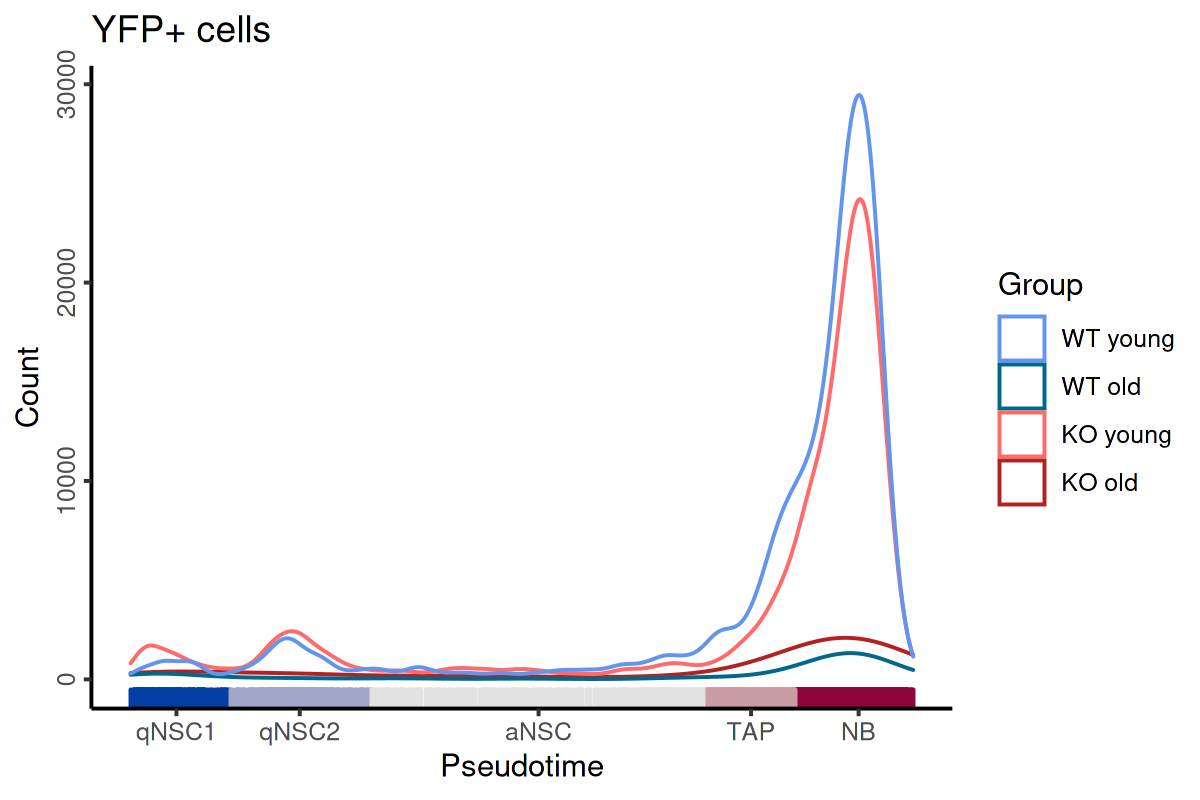

In [10]:
options(repr.plot.width=6, repr.plot.height=4)
cols <- data.frame(celltype2=c("qNSC1", "qNSC2", "aNSC", "TAP", "NB"),
                   col=hcl.colors(5, "Blue-Red")[1:5])
labs <- obs %>%
    filter(!is.na(celltype2)) %>%
    group_by(celltype2) %>%
    summarise(dpt_pseudotime=mean(range(dpt_pseudotime))) %>%
    left_join(cols)
obs %>%
    #mutate(dpt_pseudotime=rank(dpt_pseudotime)) %>%
    left_join(enframe(mat[,"EYFP"], name="barcode", value="expression")) %>%
    filter(!is.na(celltype2), expression>0) %>%
    mutate(celltype2=factor(celltype2, type.order)) %>%
    ggplot(aes(dpt_pseudotime)) +
    scale_colour_manual(values=c("WT young"="cornflowerblue", "WT old"="deepskyblue4", "KO young"="indianred1", "KO old"="firebrick")) +
    labs(title="YFP+ cells", colour="Group", y="Count", x="Pseudotime") +
    geom_density(aes(y=after_stat(count), colour=paste(genotype, age))) +
    new_scale_colour() +
    geom_rug(aes(colour=celltype2), sides="b", alpha=1) +
    labs(colour="Celltype") +
    scale_colour_manual(breaks=labs$celltype2, values=labs$col, guide=F) +
    scale_x_continuous(breaks=labs$dpt_pseudotime, labels=labs$celltype2)
dev.print(pdf, "plots/pseudotime_yfp.pdf", height=4, width=6)
dev.print(svglite::svglite, "plots/pseudotime_yfp.svg", width=6, height=4, fix_text_size=F)

In [11]:
colnames(mat)[startsWith(colnames(mat), "Ifn")]

[1] "Ifngr1" "Ifnar2" "Ifnar1" "Ifngr2" "Ifnab"  "Ifnz"   "Ifnlr1"

Joining, by = "barcode"

Warning message:
“All elements of `...` must be named.
Did you want `data = c(barcode, name, value, celltype, celltype1, celltype2, dpt_pseudotime, 
    svz_frac, hto_sum, leiden, dbscan, frac_mito, counts, genes, 
    scrub_score, age, genotype, UMAP1, UMAP2, hto_ass, hto_repl, 
    hto_zone)`?”
Warning message:
“Removed 4952 rows containing missing values (geom_point).”
Warning message:
“Removed 4204 rows containing missing values (geom_point).”
Warning message:
“Removed 3916 rows containing missing values (geom_point).”
Warning message:
“Removed 2420 rows containing missing values (geom_point).”


png 
  2

png 
  2

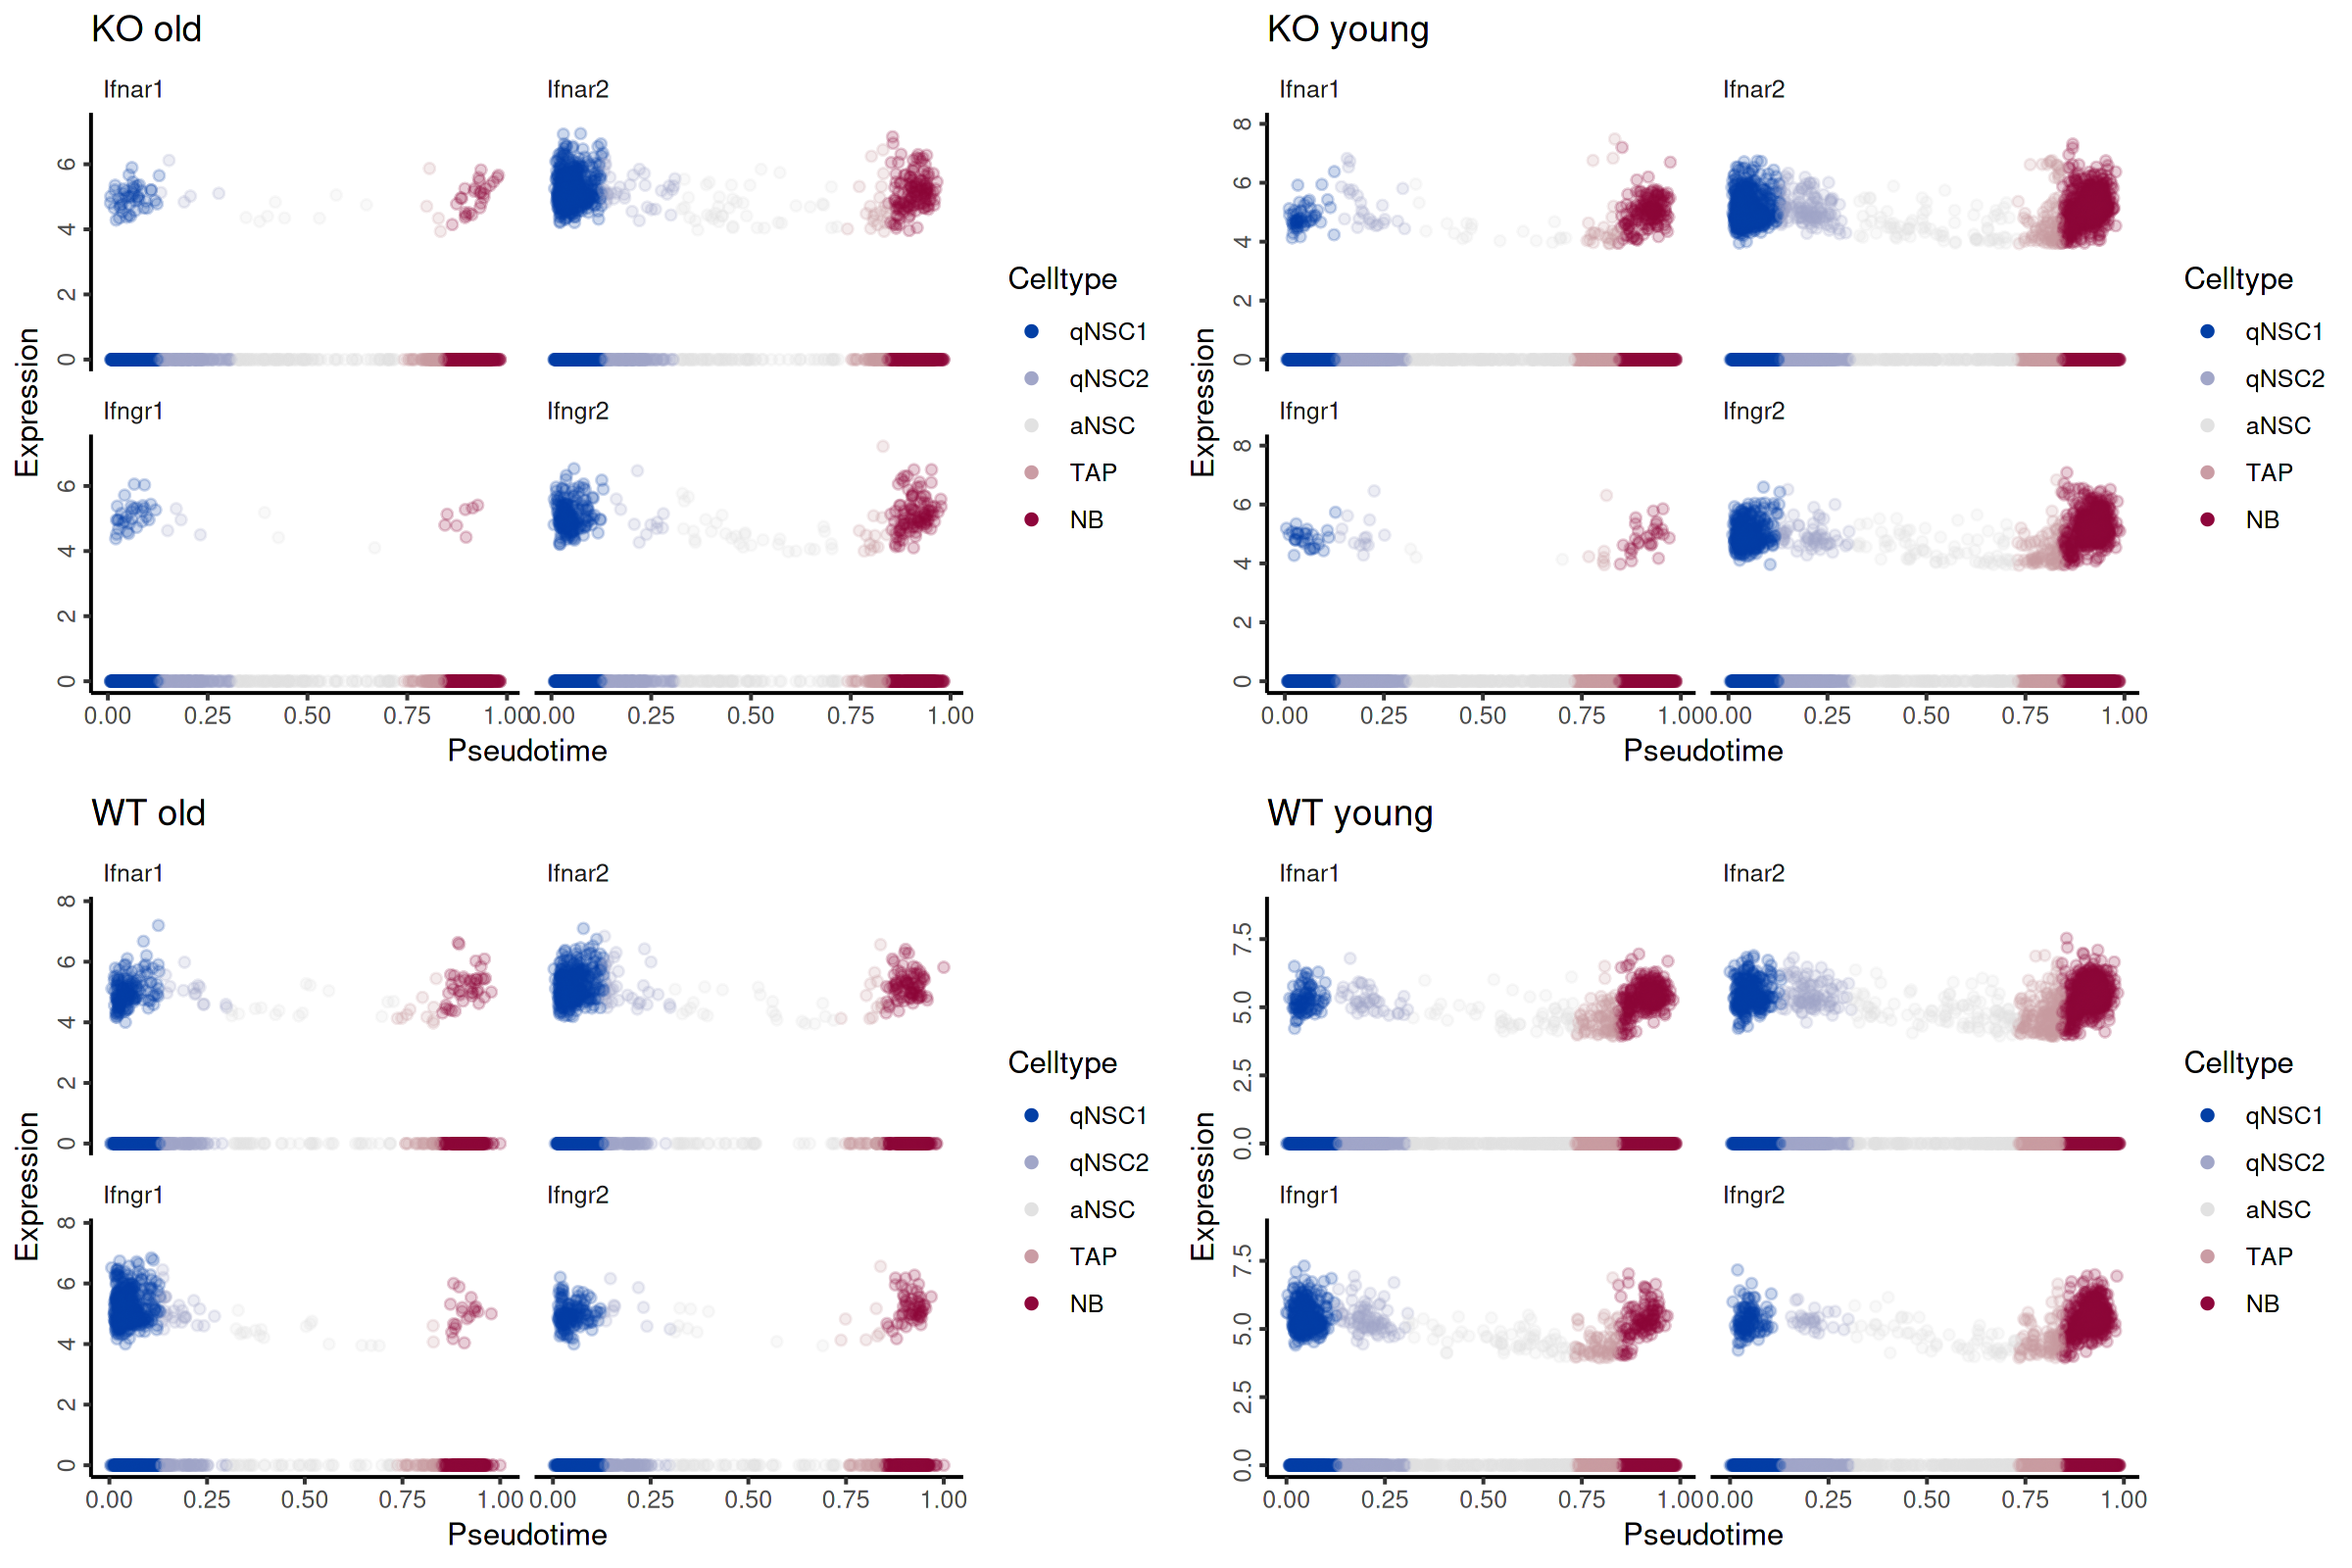

In [13]:
options(repr.plot.width=12, repr.plot.height=8)
ps <- log1p(1e6*frac[,c("Ifnar1", "Ifnar2", "Ifngr1", "Ifngr2")]) %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(barcode=rownames(.)) %>%
    pivot_longer(-barcode) %>%
    left_join(obs) %>%
    mutate(celltype=str_remove(celltype, "lineage:")) %>%
    #filter(celltype %in% type.order) %>%
    mutate(celltype=factor(celltype, type.order)) %>%
    #filter(genotype == "WT") %>%
    mutate(group=paste(genotype, age)) %>%
    nest(-group) %>%
    arrange(group) %>%
    deframe %>%
    #map2(., names(.), ~ggplot(.x, aes(dpt_pseudotime, value, colour=celltype)) + geom_point_rast(alpha=0.2, raster.dpi=400) + geom_smooth(colour="black", se=F) + scale_colour_manual(values=this.cols[1:5]) + labs(y="Expression", x="Pseudotime", colour="Celltype", title=.y) + facet_wrap(~name) + guides(colour=guide_legend(override.aes=list(alpha=1))))
    map2(., names(.), ~ggplot(.x, aes(dpt_pseudotime, value, colour=celltype)) + geom_point_rast(alpha=0.2, raster.dpi=400)  + scale_colour_manual(values=this.cols[1:5]) + labs(y="Expression", x="Pseudotime", colour="Celltype", title=.y) + facet_wrap(~name) + guides(colour=guide_legend(override.aes=list(alpha=1))))
do.call(grid.arrange, ps)
dev.print(pdf, "plots/pseudotime_receptors.pdf", height=8, width=12)
dev.print(svglite::svglite, "plots/pseudotime_receptors.svg", width=12, height=8, fix_text_size=F)

Joining, by = "barcode"

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 15492 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 15492 rows containing missing values (geom_point).”


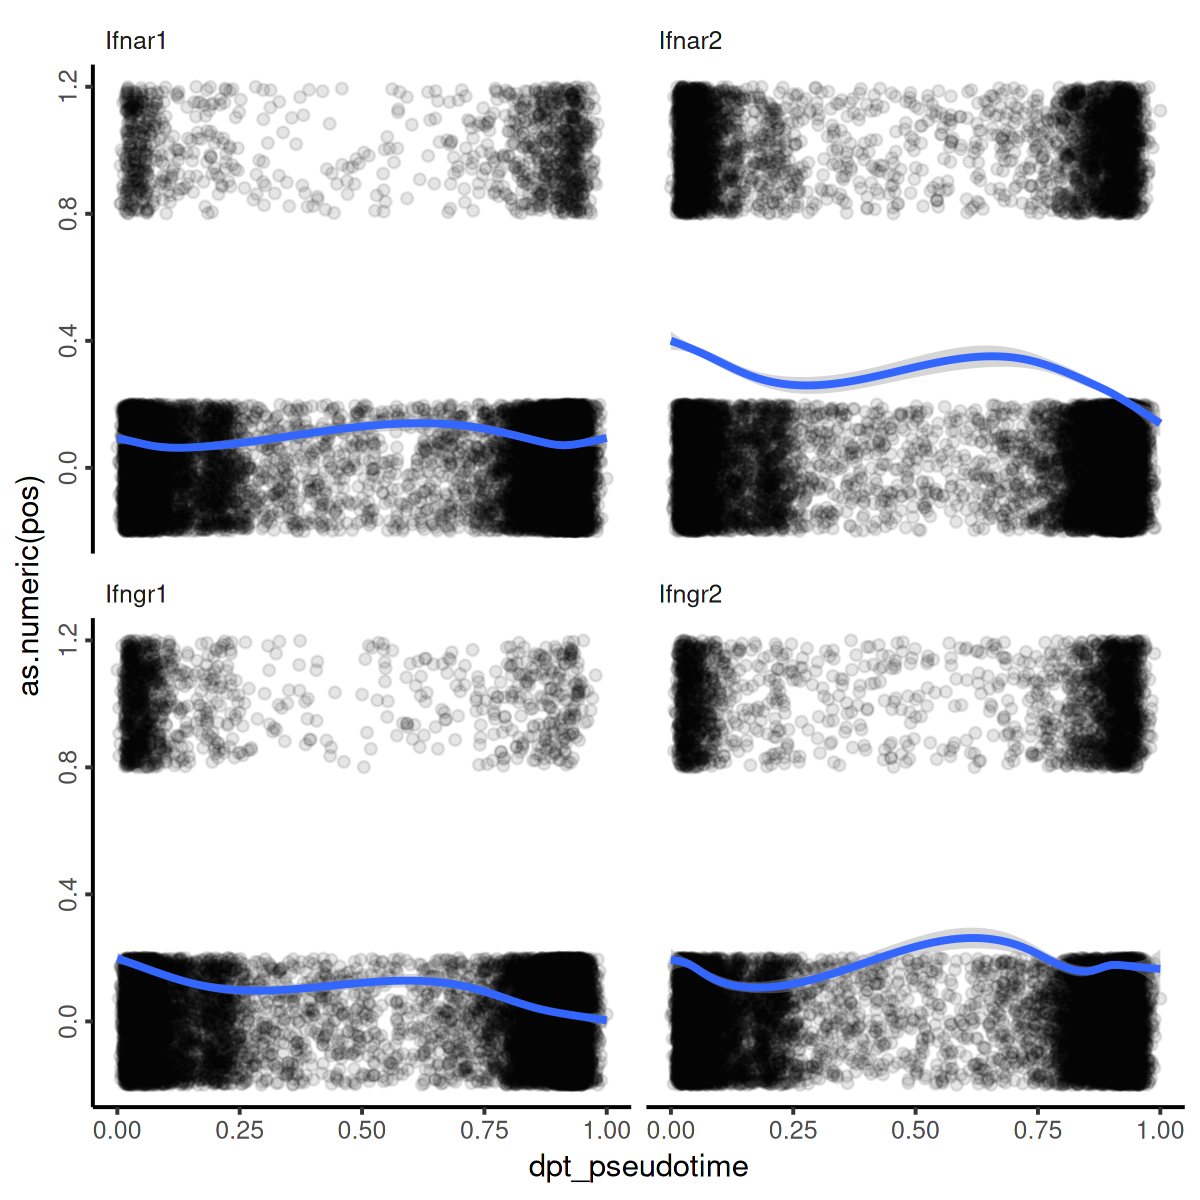

In [14]:
options(repr.plot.width=6, repr.plot.height=6)
log1p(1e6*frac[,c("Ifnar1", "Ifnar2", "Ifngr1", "Ifngr2")]) %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(barcode=rownames(.)) %>%
    pivot_longer(-barcode) %>%
    mutate(pos=value>0) %>%
    left_join(obs) %>%
    ggplot(aes(dpt_pseudotime, as.numeric(pos))) +
    geom_jitter(alpha=0.1, width=0, height=0.2) +
    geom_smooth() +
    facet_wrap(~name)

Joining, by = "barcode"



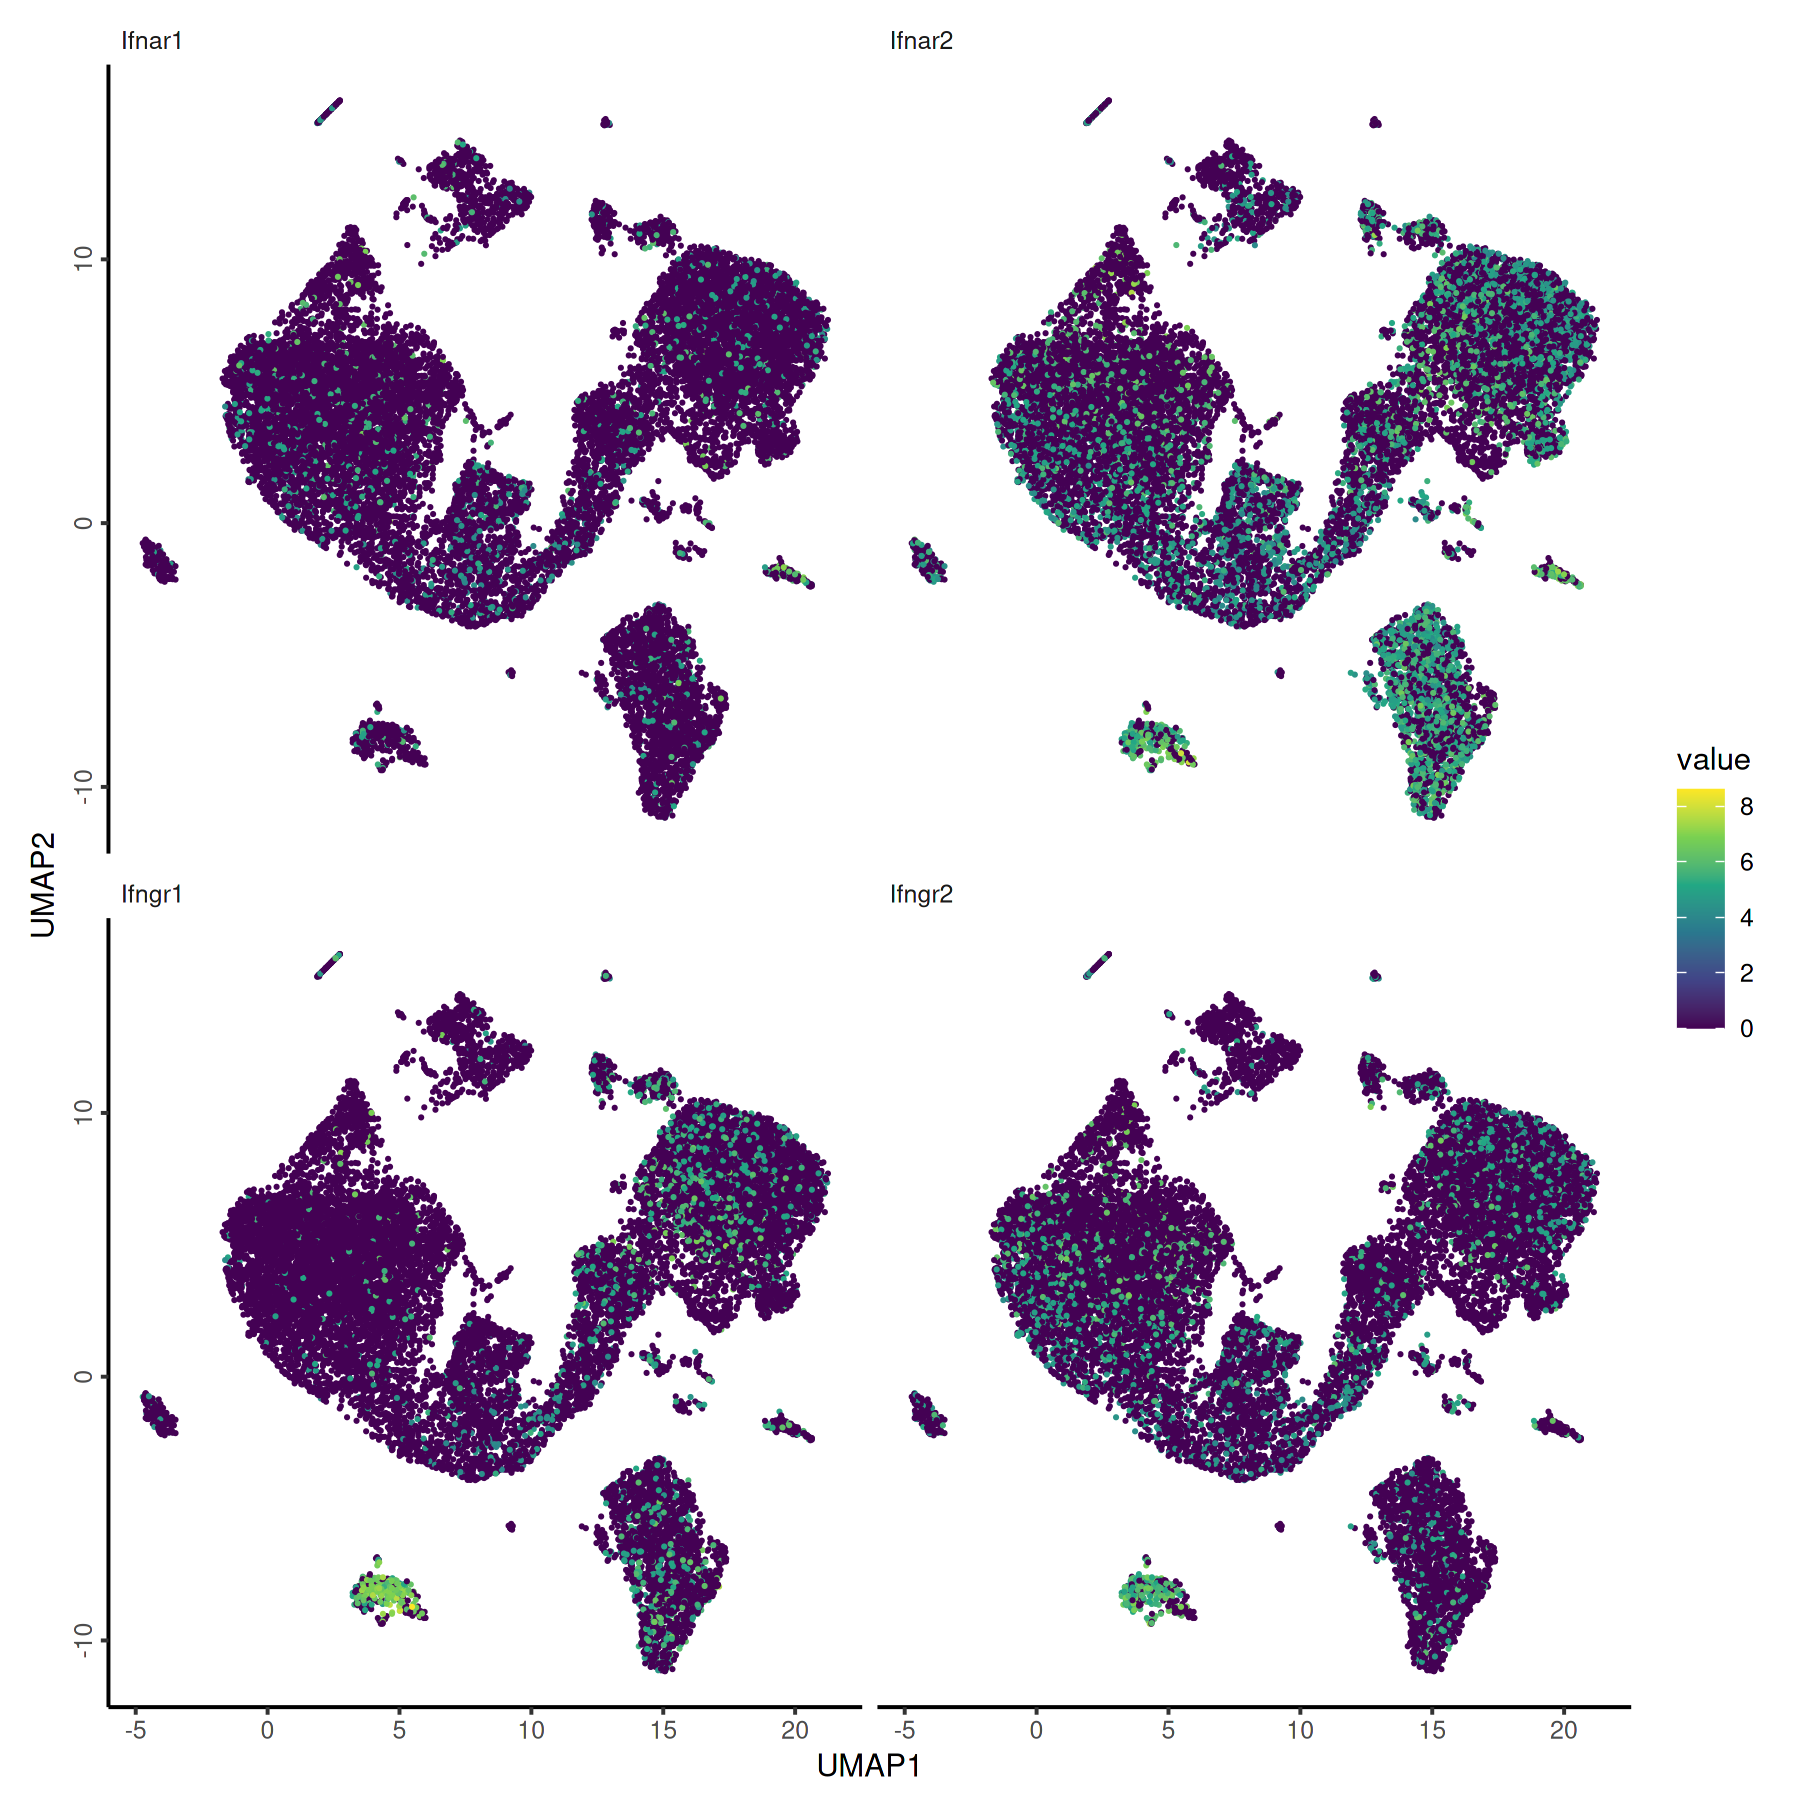

In [15]:
options(repr.plot.width=9, repr.plot.height=9)
log1p(1e6*frac[,c("Ifnar1", "Ifnar2", "Ifngr1", "Ifngr2")]) %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(barcode=rownames(.)) %>%
    pivot_longer(-barcode) %>%
    left_join(obs) %>%
    ggplot(aes(UMAP1, UMAP2, colour=value)) +
    coord_fixed() +
    geom_point(size=0.1) +
    facet_wrap(~name)

In [16]:
mat[1:9,1:9]

9 x 9 sparse Matrix of class "dgTMatrix"
                                  Xkr4 Rp1 Sox17 Gm37323 Mrpl15 Lypla1 Tcea1
AAACCCAGTCTCCTGT-WT_20mo_2021_001    .   .     .       .      .      .     5
AAACGAAAGGTACTGG-WT_20mo_2021_001    .   .     .       .      .      .     .
AAACGAACATGGCTGC-WT_20mo_2021_001    .   .     .       .      .      .     1
AAACGAAGTAGCTGAG-WT_20mo_2021_001    .   .     .       .      .      .     .
AAACGAATCACCCTCA-WT_20mo_2021_001    .   .     .       .      1      .     1
AAACGCTAGGGCAGGA-WT_20mo_2021_001    .   .     .       .      .      .     3
AAACGCTTCAGTCTTT-WT_20mo_2021_001    .   .     .       .      .      .     2
AAAGAACAGAGATTCA-WT_20mo_2021_001    .   .     .       .      .      .     .
AAAGAACAGAGCAGAA-WT_20mo_2021_001    .   .     .       .      .      .     2
                                  Rgs20 Atp6v1h
AAACCCAGTCTCCTGT-WT_20mo_2021_001     .       .
AAACGAAAGGTACTGG-WT_20mo_2021_001     .       1
AAACGAACATGGCTGC-WT_20mo_2021_001     1      

In [17]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libopenblasp-r0.3.14.so
LAPACK: /usr/lib/liblapack.so.3.9.1

locale:
 [1] LC_CTYPE=en_DK.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_DK.UTF-8        LC_COLLATE=en_DK.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_DK.UTF-8   
 [7] LC_PAPER=en_DK.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_DK.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] gridExtra_2.3    ggrastr_0.2.3    ggnewscale_0.4.5 forcats_0.5.1   
 [5] stringr_1.4.0    dplyr_1.0.7      purrr_0.3.4      readr_2.0.1     
 [9] tidyr_1.1.3      tibble_3.1.4     ggplot2_3.3.5    tidyverse_1.3.1 
[13] Matrix_1.3-4    

loaded via a namespace (and not attached):
 [1] httr_1.4.2        viridis